# Donkey Car IMU Model

Build and run a Keras model copied from Donkey Car.

* The IMU model has been modified to accept larger telemetry inputs
* RNN-LSTM has been modified to accept IMU/telemetry

In [1]:
## Imports
import numpy as np
import pandas as pd
import tensorflow as tf
import time
import pickle
import sklearn.metrics as metrics
from os.path import exists

from modeling_methods import run_model, plot_metrics, save_model, create_donkey_vimu
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from tensorflow.keras.metrics import MAE, MSE, RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

2022-01-21 21:19:32.465356: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Directories/Variables

In [2]:
## Fill in your own here
dataset_directory = '../data/01_21_2022/21_14_34'

In [3]:
## Directories
model_directory = f'../models'

## File paths
cam_input_dataset_file = f'{dataset_directory}/X_img.npy'
telem_input_dataset_file = f'{dataset_directory}/X_telem.pkl'
target_dataset_file = f'{dataset_directory}/y.npy'

## Parameters
scaler_type = 'robust' # minmax/robust/standard 
batch_sizes = [32, 64, 128, 256, 512, 1024]
early_stop_patience = 5 # None for no stop
epochs = 100
dual_outputs = False
create_model = create_donkey_vimu

In [4]:
scalers = {
    'minmax': MinMaxScaler,
    'robust': RobustScaler,
    'standard': StandardScaler,
}

## Data

### Load Datasets

In [5]:
## Load the datasets
X_cam = np.load(cam_input_dataset_file)

## Load telemetry as df to grab telemetry column names
telem_df = pd.read_pickle(telem_input_dataset_file)
telemetry_columns = telem_df.columns
## Convert to numpy, delete df
X_telem = telem_df.to_numpy()
del telem_df

## Load targets
y = np.load(target_dataset_file, mmap_mode='r')

## Check Shape
X_cam.shape

(51147, 120, 160, 1)

### Train-Test Split

In [6]:
if dual_outputs:
    # steering = y[:, 0], throttle = y[:, 1]
    datasets = train_test_split(X_cam, X_telem, y[:, 0], y[:, 1], test_size=0.2, random_state=0)
else:
    datasets = train_test_split(X_cam, X_telem, y, test_size=0.2, random_state=0)

del X_telem
del X_cam
    
X_cam_train = datasets[0]
X_cam_test = datasets[1]
X_telem_train = datasets[2]
X_telem_test = datasets[3]
y_train = datasets[4]
y_test = datasets[5]
    
if dual_outputs:
    y_st_train = datasets[4]
    y_st_test = datasets[5]
    y_th_train = datasets[6]
    y_th_test = datasets[7]

### Scale IMU Data

In [7]:
scaler_file = f'{scaler_type}_scaler_{time.strftime("%m_%d_%H_%M")}.pkl'
scaler_path = f'../scalers/{scaler_file}'

sc = scalers[scaler_type]()
    
## Fit to then and transform training data
X_telem_train_sc = sc.fit_transform(X_telem_train)
## Transform testing data
X_telem_test_sc = sc.transform(X_telem_test)

### Save the Scaler for Predictions

In [8]:
## Save as pickle
pickle.dump(sc, open(scaler_path, 'wb'))

## Print path
scaler_file

'robust_scaler_01_21_21_19.pkl'

### Get Input Shape(s)

In [9]:
## Create variables
img_input_shape = X_cam_train[0].shape
tel_input_shape = X_telem_train_sc[0].shape

## Check telemetry input shape
tel_input_shape

(3,)

## Model Loop

---
Batch size 32 start: 21:20:03


2022-01-21 21:20:03.511076: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3142425600 exceeds 10% of free system memory.


Epoch 1/250
1279/1279 [==============================] - ETA: 0s - loss: 0.2627 - mae: 0.3785 - root_mean_squared_error: 0.5104

2022-01-21 21:20:39.807590: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 785664000 exceeds 10% of free system memory.


1279/1279 [==============================] - 45s 35ms/step - loss: 0.2627 - mae: 0.3785 - root_mean_squared_error: 0.5103 - val_loss: 0.1320 - val_mae: 0.2773 - val_root_mean_squared_error: 0.3633
Epoch 2/250
1279/1279 [==============================] - 17s 13ms/step - loss: 0.1140 - mae: 0.2424 - root_mean_squared_error: 0.3371 - val_loss: 0.0512 - val_mae: 0.1508 - val_root_mean_squared_error: 0.2262
Epoch 3/250
1279/1279 [==============================] - 17s 14ms/step - loss: 0.0739 - mae: 0.1887 - root_mean_squared_error: 0.2719 - val_loss: 0.0446 - val_mae: 0.1302 - val_root_mean_squared_error: 0.2113
Epoch 4/250
1279/1279 [==============================] - 17s 13ms/step - loss: 0.0645 - mae: 0.1719 - root_mean_squared_error: 0.2539 - val_loss: 0.0389 - val_mae: 0.1112 - val_root_mean_squared_error: 0.1971
Epoch 5/250
1279/1279 [==============================] - 17s 13ms/step - loss: 0.0573 - mae: 0.1609 - root_mean_squared_error: 0.2394 - val_loss: 0.0357 - val_mae: 0.1062 - val

2022-01-21 21:28:06.986408: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3142425600 exceeds 10% of free system memory.


Epoch 1/250
637/640 [============================>.] - ETA: 0s - loss: 0.2886 - mae: 0.4066 - root_mean_squared_error: 0.5346

2022-01-21 21:28:39.848783: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 785664000 exceeds 10% of free system memory.


640/640 [==============================] - 41s 36ms/step - loss: 0.2882 - mae: 0.4063 - root_mean_squared_error: 0.5343 - val_loss: 0.1470 - val_mae: 0.2836 - val_root_mean_squared_error: 0.3834
Epoch 2/250
640/640 [==============================] - 14s 22ms/step - loss: 0.1400 - mae: 0.2718 - root_mean_squared_error: 0.3733 - val_loss: 0.0702 - val_mae: 0.1874 - val_root_mean_squared_error: 0.2649
Epoch 3/250
640/640 [==============================] - 14s 22ms/step - loss: 0.0868 - mae: 0.2059 - root_mean_squared_error: 0.2946 - val_loss: 0.0531 - val_mae: 0.1489 - val_root_mean_squared_error: 0.2305
Epoch 4/250
640/640 [==============================] - 14s 22ms/step - loss: 0.0726 - mae: 0.1834 - root_mean_squared_error: 0.2695 - val_loss: 0.0491 - val_mae: 0.1406 - val_root_mean_squared_error: 0.2216
Epoch 5/250
640/640 [==============================] - 14s 22ms/step - loss: 0.0666 - mae: 0.1735 - root_mean_squared_error: 0.2581 - val_loss: 0.0435 - val_mae: 0.1241 - val_root_mean

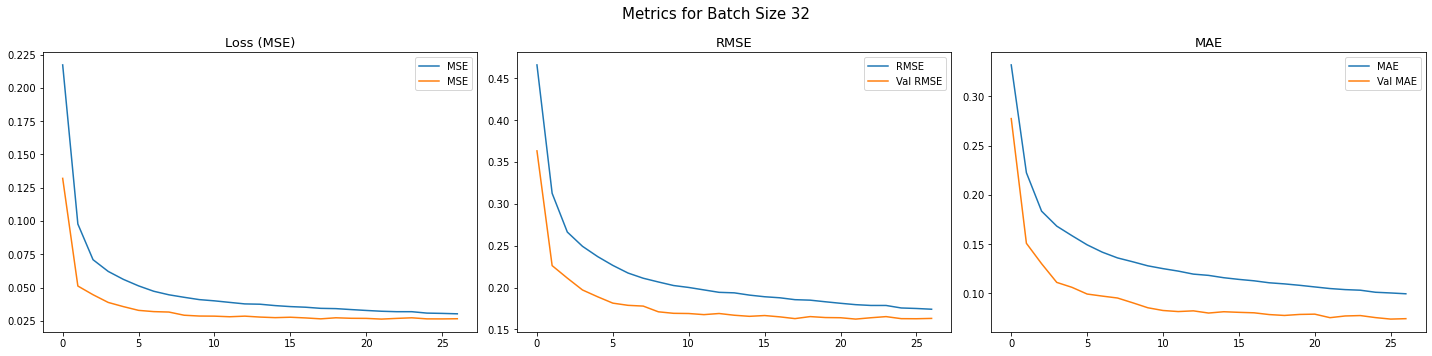

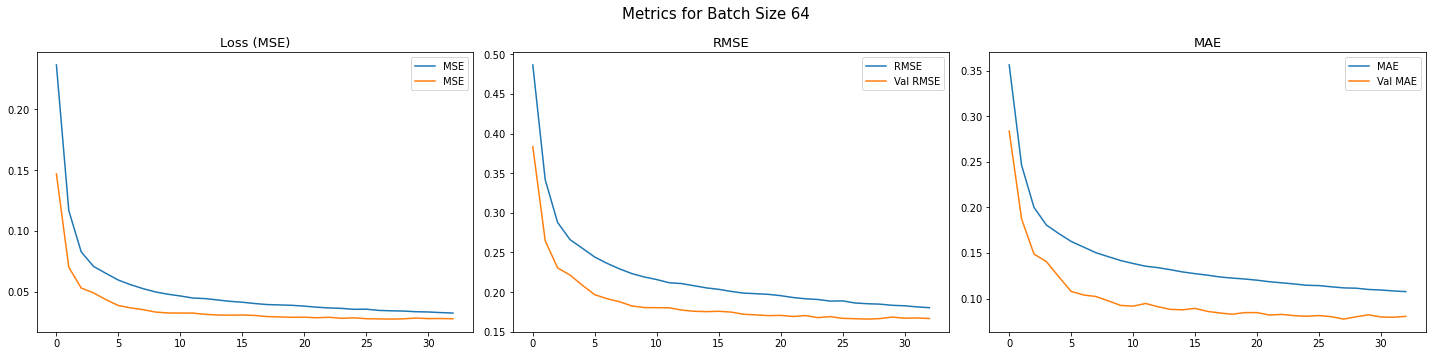

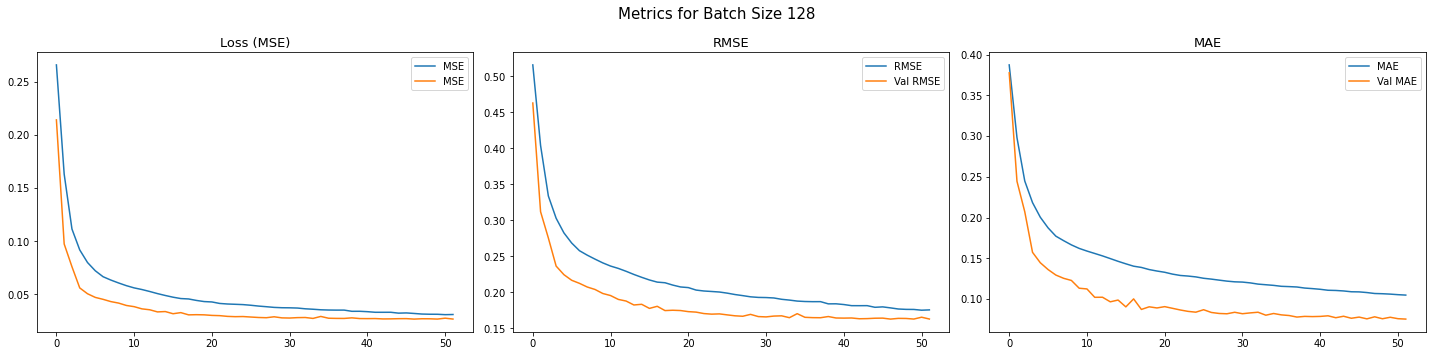

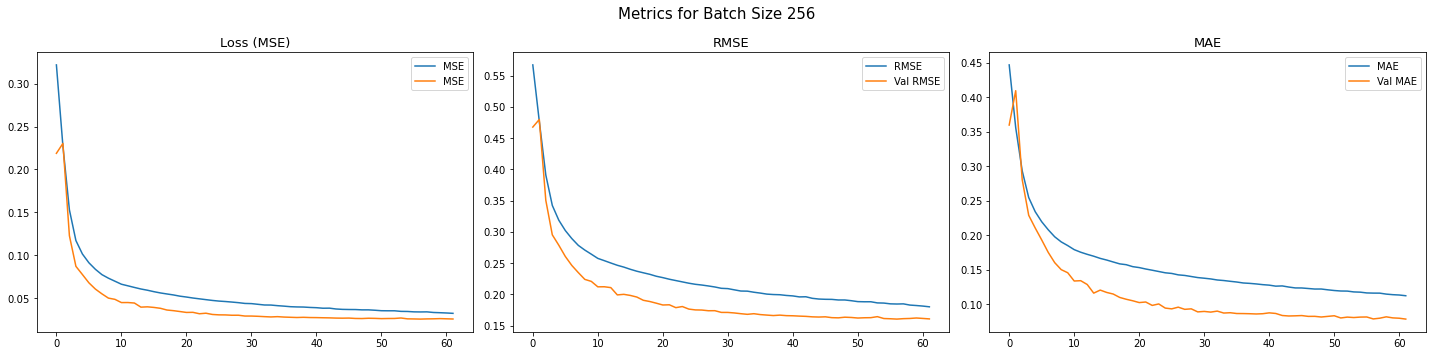

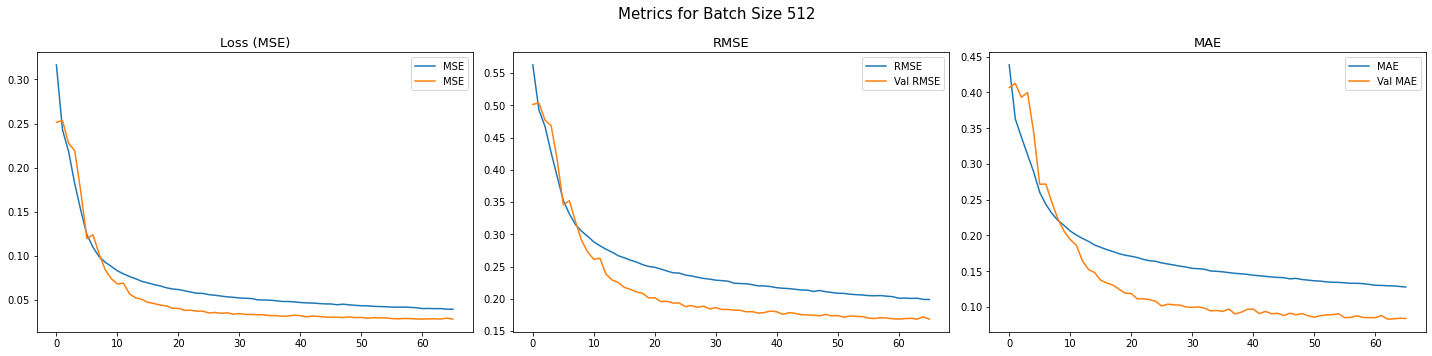

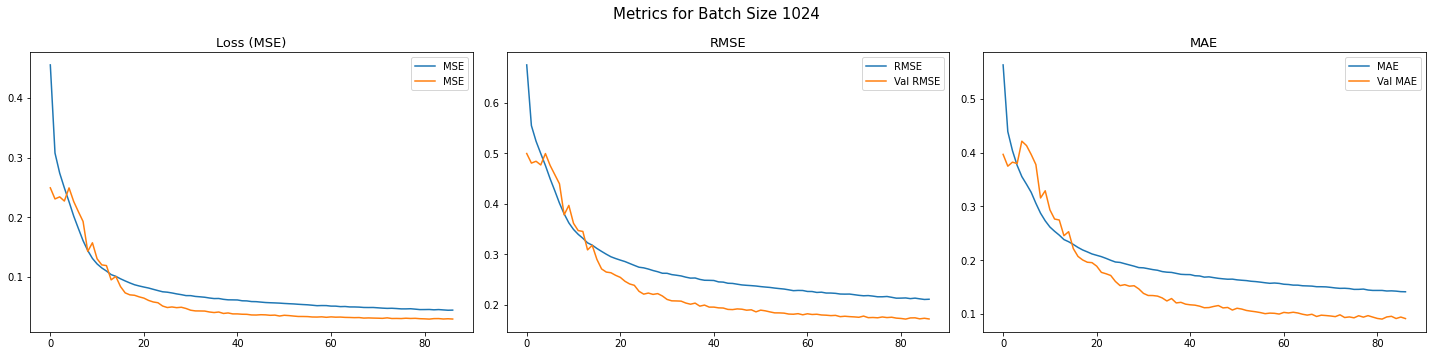

In [11]:
X_train = [X_cam_train, X_telem_train_sc]
X_test = (X_cam_test, X_telem_test_sc)


if dual_outputs:
    y_train = (y_st_train, y_th_train)
    y_test = (y_st_test, y_th_test)
else:
    y_train = y_train
    y_test = y_test

## Run models for each batch size
print('---')
for batch_size in batch_sizes:
    print(f'Batch size {batch_size} start: {time.strftime("%H:%M:%S")}')
    model = create_model(img_input_shape, tel_input_shape, dual_outputs)
    model.compile(loss='mse', 
                  optimizer=Adam(learning_rate=0.0001), 
                  metrics=['mae', RootMeanSquaredError()])
    model, results = run_model(model, X_train, y_train, X_test, y_test, 
                               batch_size, epochs,
                              early_stop_patience=early_stop_patience)
    model_file = save_model(model_directory, model, results, batch_size, 
                            dual_outputs, scaler_file, telemetry_columns)
    history = {k: v for k, v in results.history.items()}
    plot_metrics(history, batch_size, dual_outputs)
    print(f'Batch size {batch_size} end:   {time.strftime("%H:%M:%S")}')
    print(f'Epochs run: {len(history["loss"])}')
    print(f'model: {model_file}')
    print('---')
    del model
    del results